In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def gradSigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

def fwdPropagate(input, weights, biases):
    W1, W2 = weights
    b1, b2 = biases

    a1 = input @ W1 + b1
    z1 = sigmoid(a1)

    a2 = z1 @ W2 + b2
    # Since output layer has only one node, we can use sigmoid activation
    y_hat = sigmoid(a2)

    return a1, z1, a2, y_hat

def computeGradients(inputs, targets, weights, activations):
    a1, z1, a2, y_hat = activations
    W1, W2 = weights

    # using squared error loss and sigmoid activation for the last layer
    del2 = 2*(y_hat - targets)/len(targets) * gradSigmoid(a2)
    dj_dW2 = z1.T @ del2
    dj_db2 = np.sum(del2, axis=0)

    del1 = (del2 @ W2.T) * gradSigmoid(a1)
    dj_dW1 = inputs.T @ del1
    dj_db1 = np.sum(del1, axis=0)

    return [dj_dW1, dj_db1, dj_dW2, dj_db2]

def applyGradients(weights, biases, gradients, learning_rate):
    W1, W2 = weights
    b1, b2 = biases
    dj_dW1, dj_db1, dj_dW2, dj_db2 = gradients

    W1 = W1 - learning_rate * dj_dW1
    b1 = b1 - learning_rate * dj_db1
    W2 = W2 - learning_rate * dj_dW2
    b2 = b2 - learning_rate * dj_db2

    return [W1, W2], [b1, b2]

def backPropagate(inputs, targets, weights, biases, activations, learning_rate):
    gradients = computeGradients(inputs, targets, weights, activations)
    weights, biases = applyGradients(weights, biases, gradients, learning_rate)
    return weights, biases

def predict(inputs, weights, biases):
    a1, z1, a2, y_hat = fwdPropagate(inputs, weights, biases)
    return y_hat

def accuracy(y, y_hat):
    if y.shape[1] == 1:
        return np.sum(y == np.round(y_hat))/len(y)
    return np.sum(np.argmax(y, axis=1) == np.argmax(y_hat, axis=1))/len(y)

In [3]:
def training(inputs, targets, test_inputs, test_targets, hidden_layer_nodes, output_layer_nodes, epoch, learning_rate, training_method, batch_size=8):
    # If output layer has more than one node, convert the targets to one-hot encoding
    if output_layer_nodes != 1:
        targets_ = np.zeros((targets.size, targets.max()+1))
        targets_[np.arange(targets.size), targets.astype(int)] = 1
        targets = targets_

        test_targets_ = np.zeros((test_targets.size, test_targets.max()+1))
        test_targets_[np.arange(test_targets.size), test_targets.astype(int)] = 1
        test_targets = test_targets_
    else:
        targets = np.array(targets).reshape(-1, 1)
        test_targets = np.array(test_targets).reshape(-1, 1)
    
    # Initialize weights and biases
    W1 = np.random.uniform(-1, 1, (inputs.shape[1], hidden_layer_nodes)).astype(np.float64)
    b1 = np.random.uniform(-1, 1, (1, hidden_layer_nodes)).astype(np.float64)
    W2 = np.random.uniform(-1, 1, (hidden_layer_nodes, output_layer_nodes)).astype(np.float64)
    b2 = np.random.uniform(-1, 1, (1, output_layer_nodes)).astype(np.float64)

    weights = [W1, W2]
    biases = [b1, b2]

    train_acc = []
    train_loss = []
    test_acc = []
    test_loss = []
    
    for i in range(epoch):

        if training_method == 'deterministic_gradient_descent':
            activations = fwdPropagate(inputs, weights, biases)
            weights, biases = backPropagate(inputs, targets, weights, biases, activations, learning_rate)
        
        elif training_method == 'stochastic_gradient_descent':
            # shuffle the data
            indices = np.arange(len(inputs))
            np.random.shuffle(indices)
            inputs = inputs[indices]
            targets = targets[indices]
            
            # update weights and biases for small batches
            for i in range(len(inputs)//batch_size):
                batch_inputs = inputs[i*batch_size:(i+1)*batch_size]
                batch_targets = targets[i*batch_size:(i+1)*batch_size]
                activations = fwdPropagate(batch_inputs, weights, biases)
                weights, biases = backPropagate(batch_inputs, batch_targets, weights, biases, activations, learning_rate)
        
        # calculate loss and accuracy for each epoch
        activations = fwdPropagate(inputs, weights, biases)
        train_loss.append(np.sum((activations[-1] - targets) ** 2)/len(targets))
        train_acc.append(accuracy(targets, activations[-1]))

        activations = fwdPropagate(test_inputs, weights, biases)
        test_loss.append(np.sum((activations[-1] - test_targets) ** 2)/len(test_targets))
        test_acc.append(accuracy(test_targets, activations[-1]))

    # plot loss and accuracy
    plt.figure()
    plt.plot(train_loss, label='Train Loss')
    plt.plot(test_loss, label='Test Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

    plt.figure()
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(test_acc, label='Test Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()
    
    print('Train Loss:', train_loss[-1])
    print('Train Accuracy:', train_acc[-1])

    print('Test Loss:', test_loss[-1])
    print('Test Accuracy:', test_acc[-1])

In [4]:
def get_data(n, operation, training_percentage=0.8, mean=0, std=0.1):
    '''
    n: number of samples from each class
    operation: 'XOR', 'AND', 'OR'
    training_percentage: percentage of data to be used for training
    '''
    X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
    if operation == 'XOR':
        y = np.array([0, 1, 1, 0])
    elif operation == 'AND':
        y = np.array([0, 0, 0, 1])
    elif operation == 'OR':
        y = np.array([0, 1, 1, 1])
    else:
        print('Invalid operation')
        return

    # Concatenate the n times then add noise
    input = np.repeat(X, n, axis=0).astype(np.float64)
    target = np.repeat(y, n, axis=0)

    # np.random.seed(10) # for reproducibility
    for i in range(len(input)):
        input[i] += np.random.normal(mean, std, 2)
    
    # shuffle the data
    indices = np.arange(len(input))
    np.random.shuffle(indices)
    input = input[indices]
    target = target[indices]

    input_train = input[:int(training_percentage*len(input))]
    target_train = target[:int(training_percentage*len(input))]

    input_test = input[int(training_percentage*len(input)):]
    target_test = target[int(training_percentage*len(input)):]

    return input_train, target_train, input_test, target_test

In [5]:
def plotPoints(X, y):
    plt.scatter(X[y==0][:,0], X[y==0][:,1], color='yellow')
    plt.scatter(X[y==1][:,0], X[y==1][:,1], color='purple')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

In [6]:
# Mean and standard deviation for noise
mean = 0
std = 0.1

# Percentage of data to be used for training
Tr = 0.8

Deterministic Gradient Descent:

In [7]:
# For n = 10 i.e., 10 samples from each cluster so total 40 samples
n = 10

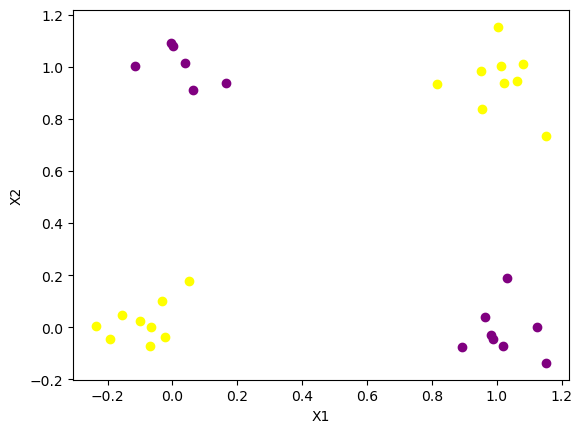

In [8]:
# XOR
input_train, target_train, input_test, target_test = get_data(n, 'XOR', Tr, mean, std)
plotPoints(input_train, target_train)

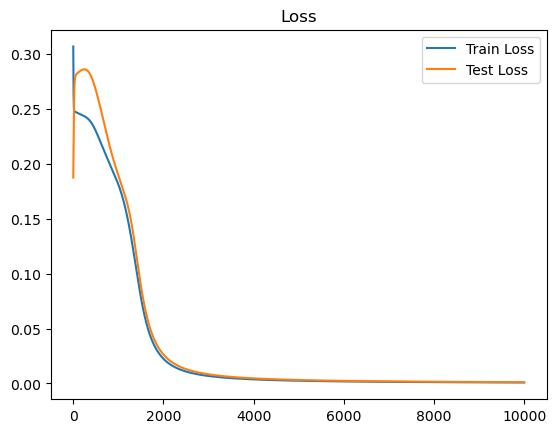

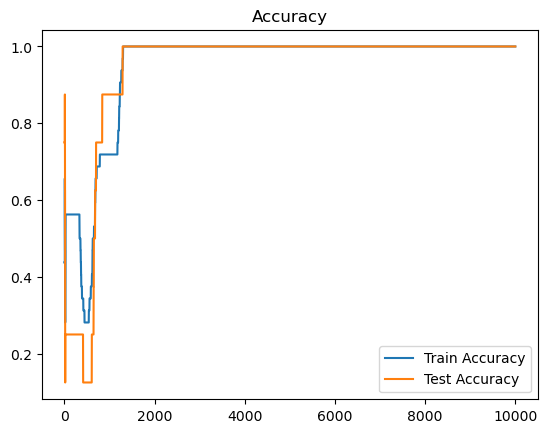

Train Loss: 0.0008737828157699983
Train Accuracy: 1.0
Test Loss: 0.001150725216308016
Test Accuracy: 1.0


In [9]:
xor_params = training(input_train, target_train, input_test, target_test, 2, 1, 10000, 0.5, 'deterministic_gradient_descent')

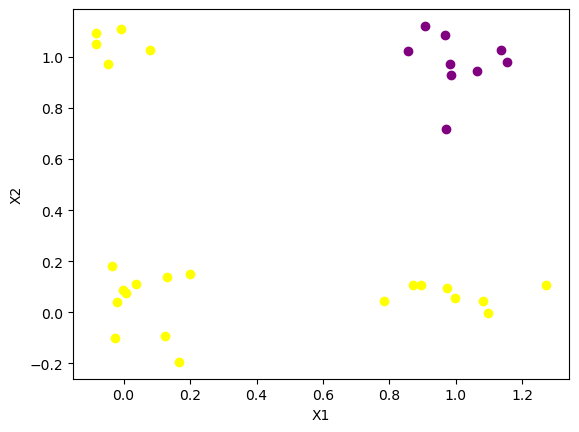

In [10]:
# AND
input_train, target_train, input_test, target_test = get_data(n, 'AND', Tr, mean, std)
plotPoints(input_train, target_train)

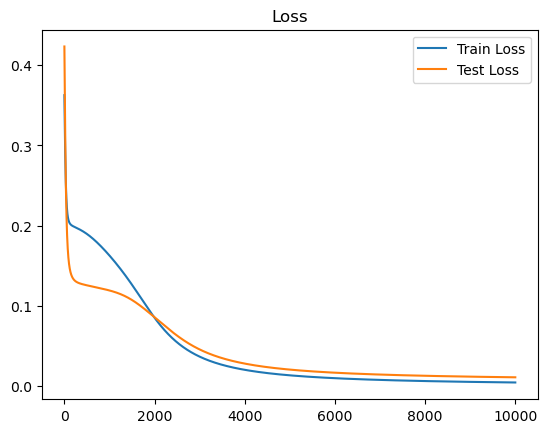

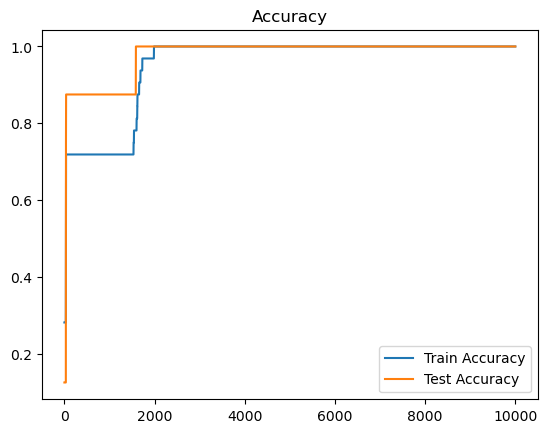

Train Loss: 0.004795155281973836
Train Accuracy: 1.0
Test Loss: 0.011236818700068662
Test Accuracy: 1.0


In [11]:
and_params = training(input_train, target_train, input_test, target_test, 2, 1, 10000, 0.1, 'deterministic_gradient_descent')

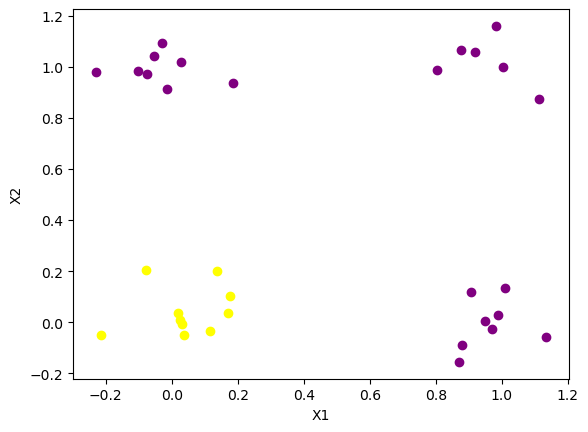

In [12]:
# OR
input_train, target_train, input_test, target_test = get_data(n, 'OR', Tr, mean, std)
plotPoints(input_train, target_train)

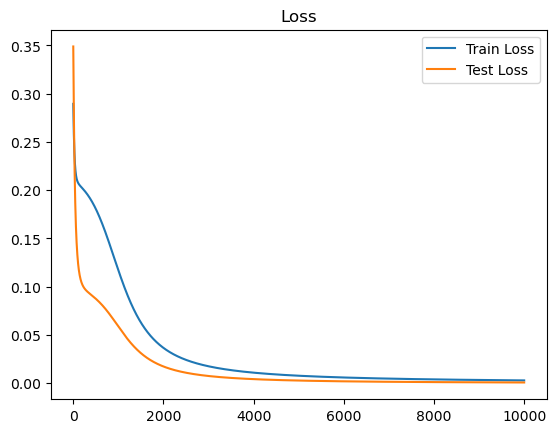

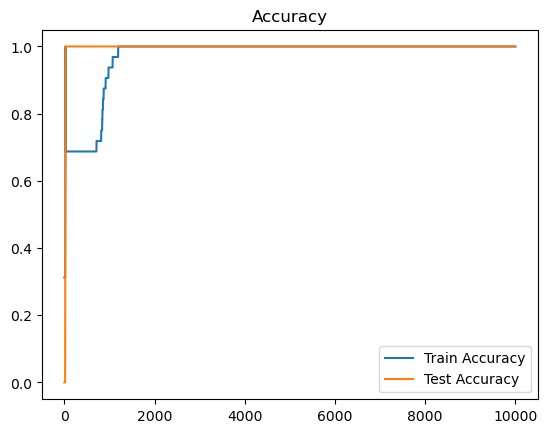

Train Loss: 0.00296075012887381
Train Accuracy: 1.0
Test Loss: 0.0008183813578663368
Test Accuracy: 1.0


In [13]:
or_params = training(input_train, target_train, input_test, target_test, 2, 1, 10000, 0.1, 'deterministic_gradient_descent')

In [14]:
# For n = 50 i.e., 50 samples from each cluster so total 200 samples
n = 50

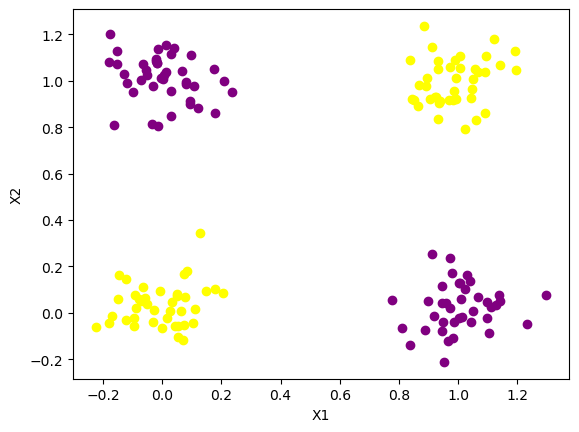

In [15]:
# XOR
input_train, target_train, input_test, target_test = get_data(n, 'XOR', Tr, mean, std)
plotPoints(input_train, target_train)

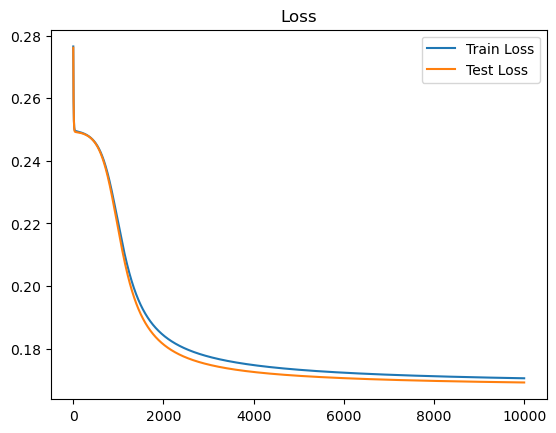

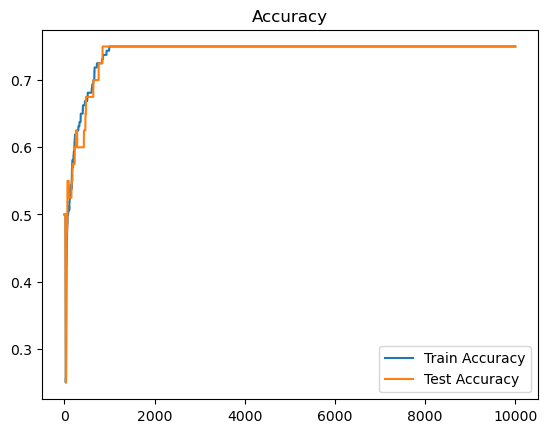

Train Loss: 0.1705009865253993
Train Accuracy: 0.75
Test Loss: 0.16915979824747368
Test Accuracy: 0.75


In [16]:
xor_params = training(input_train, target_train, input_test, target_test, 2, 1, 10000, 0.5, 'deterministic_gradient_descent')

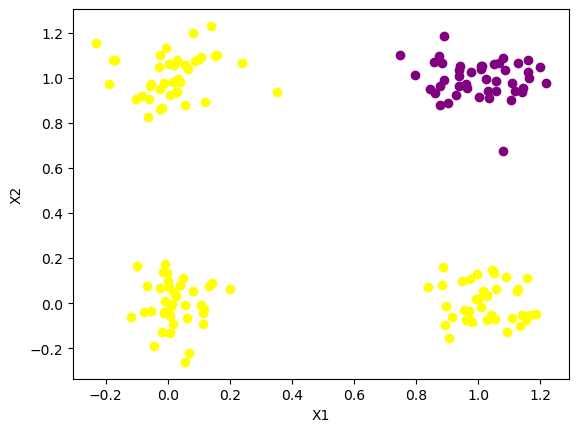

In [17]:
# AND
input_train, target_train, input_test, target_test = get_data(n, 'AND', Tr, mean, std)
plotPoints(input_train, target_train)

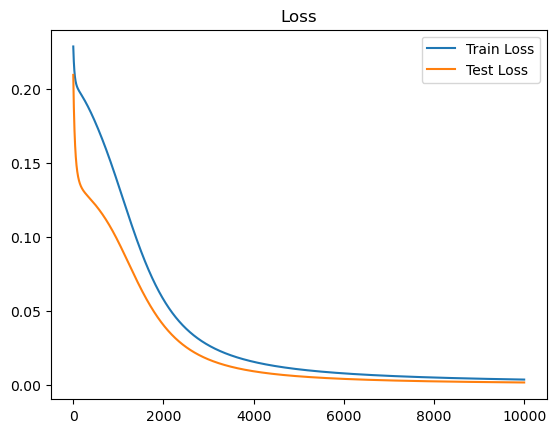

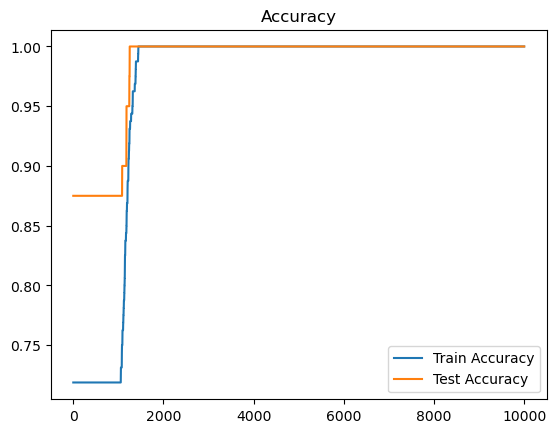

Train Loss: 0.0035310054327628063
Train Accuracy: 1.0
Test Loss: 0.001565710791548474
Test Accuracy: 1.0


In [18]:
and_params = training(input_train, target_train, input_test, target_test, 2, 1, 10000, 0.1, 'deterministic_gradient_descent')

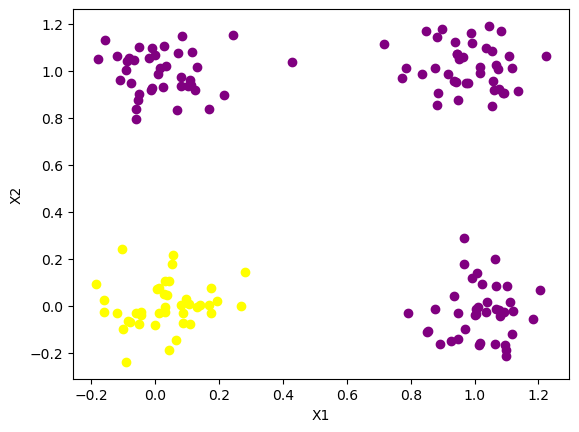

In [19]:
# OR
input_train, target_train, input_test, target_test = get_data(n, 'OR', Tr, mean, std)
plotPoints(input_train, target_train)

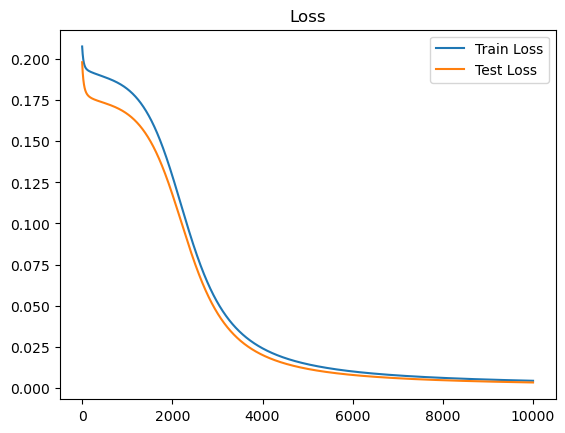

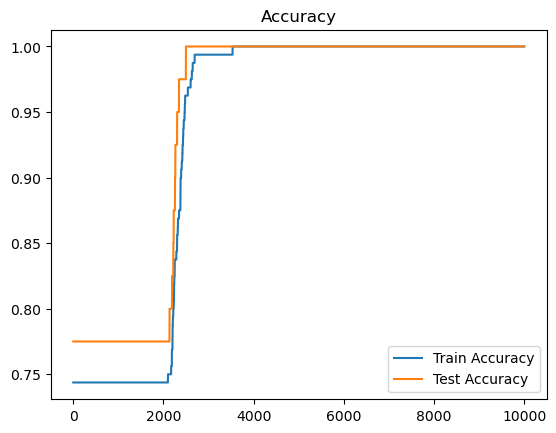

Train Loss: 0.004250883026499265
Train Accuracy: 1.0
Test Loss: 0.003212352727878458
Test Accuracy: 1.0


In [20]:
or_params = training(input_train, target_train, input_test, target_test, 2, 1, 10000, 0.1, 'deterministic_gradient_descent')

In [21]:
# For n = 100 i.e., 100 samples from each cluster so total 400 samples
n = 100

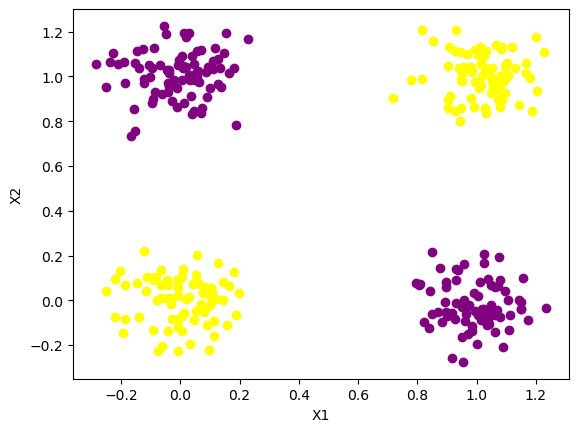

In [22]:
# XOR
input_train, target_train, input_test, target_test = get_data(n, 'XOR', Tr, mean, std)
plotPoints(input_train, target_train)

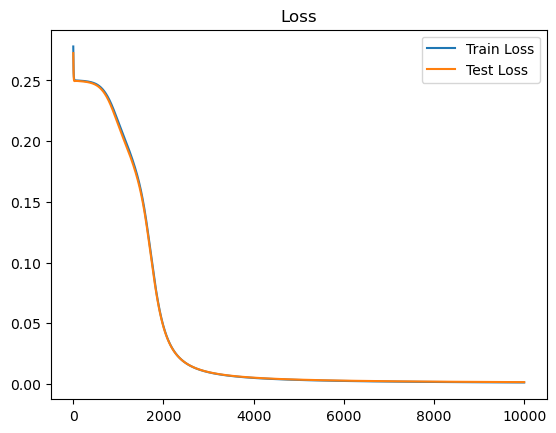

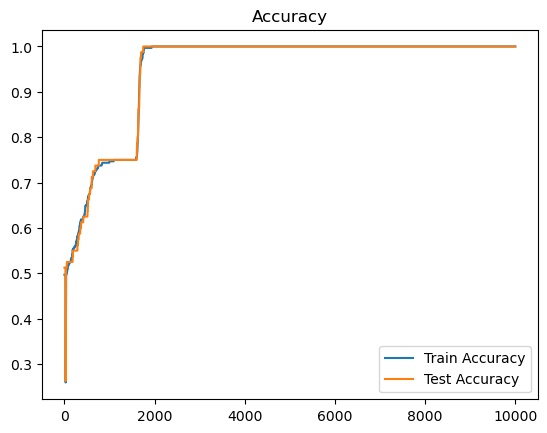

Train Loss: 0.0012722256740773385
Train Accuracy: 1.0
Test Loss: 0.0015558003461349599
Test Accuracy: 1.0


In [23]:
xor_params = training(input_train, target_train, input_test, target_test, 2, 1, 10000, 0.5, 'deterministic_gradient_descent')

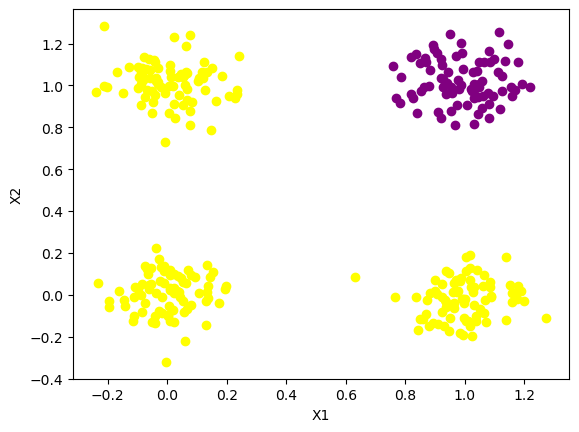

In [24]:
# AND
input_train, target_train, input_test, target_test = get_data(n, 'AND', Tr, mean, std)
plotPoints(input_train, target_train)

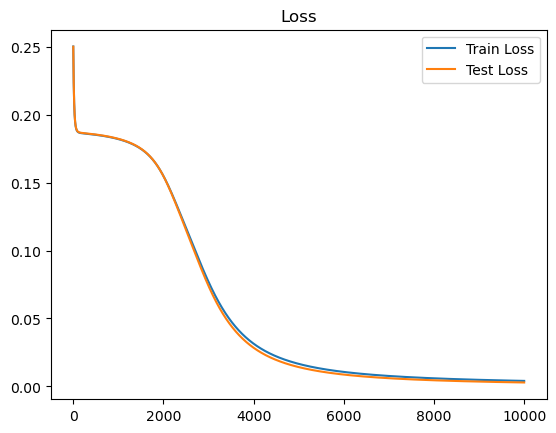

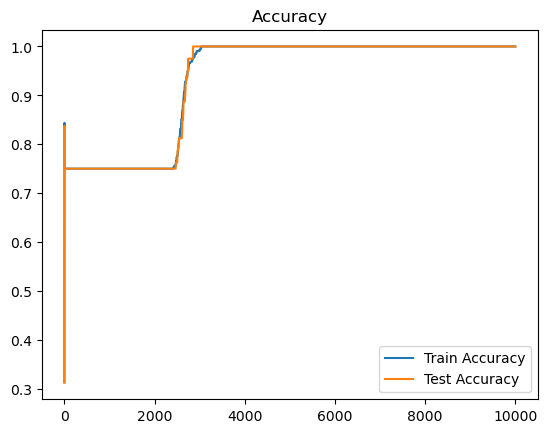

Train Loss: 0.0040302172468945725
Train Accuracy: 1.0
Test Loss: 0.0028645160911247034
Test Accuracy: 1.0


In [25]:
and_params = training(input_train, target_train, input_test, target_test, 2, 1, 10000, 0.1, 'deterministic_gradient_descent')

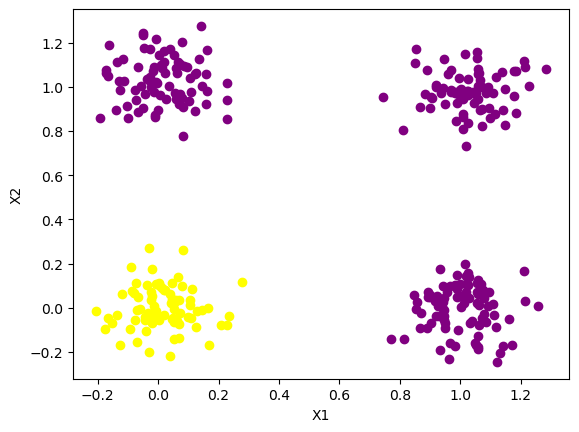

In [26]:
# OR
input_train, target_train, input_test, target_test = get_data(n, 'OR', Tr, mean, std)
plotPoints(input_train, target_train)

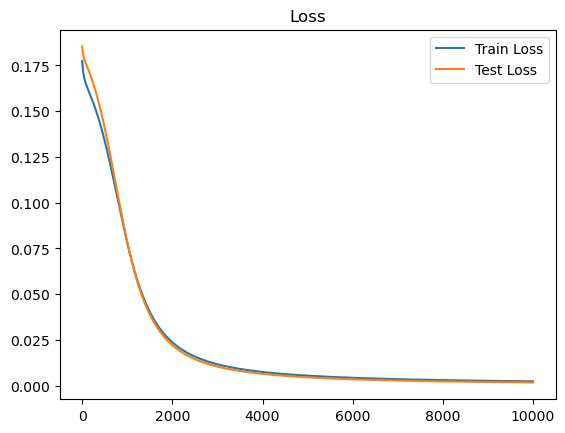

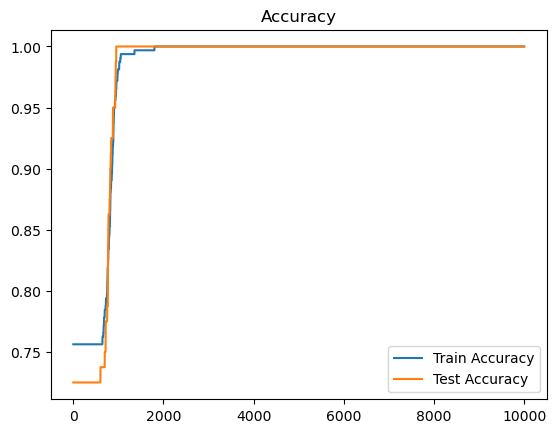

Train Loss: 0.002361792227327117
Train Accuracy: 1.0
Test Loss: 0.0017498647480713558
Test Accuracy: 1.0


In [27]:
or_params = training(input_train, target_train, input_test, target_test, 2, 1, 10000, 0.1, 'deterministic_gradient_descent')

Observations:  

1. As the number of samples increases, the training time increases linearly.  

2. For XOR, a bigger learning rate is required (0.5) to converge faster. Other datasets converge with a smaller learning rate (0.1).

  
Stochastic Gradient Descent:

In [28]:
n = 50 # number of samples from each class

In [29]:
# For batch size = 8
m = 8

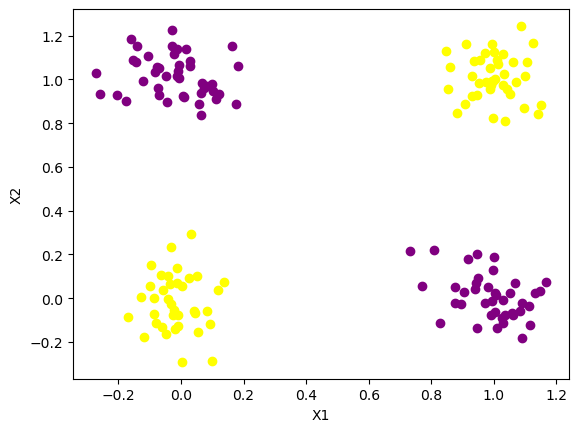

In [30]:
# XOR
input_train, target_train, input_test, target_test = get_data(n, 'XOR', Tr, mean, std)
plotPoints(input_train, target_train)

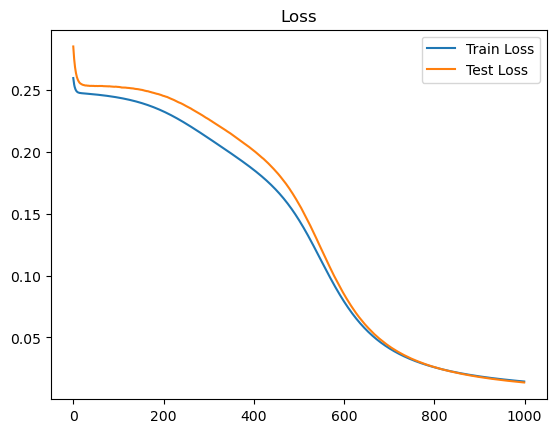

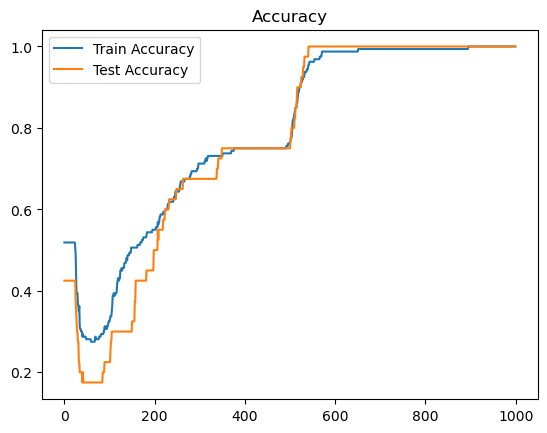

Train Loss: 0.01441026750717721
Train Accuracy: 1.0
Test Loss: 0.01361921757262154
Test Accuracy: 1.0


In [31]:
xor_params = training(input_train, target_train, input_test, target_test, 2, 1, 1000, 0.05, 'stochastic_gradient_descent', m)

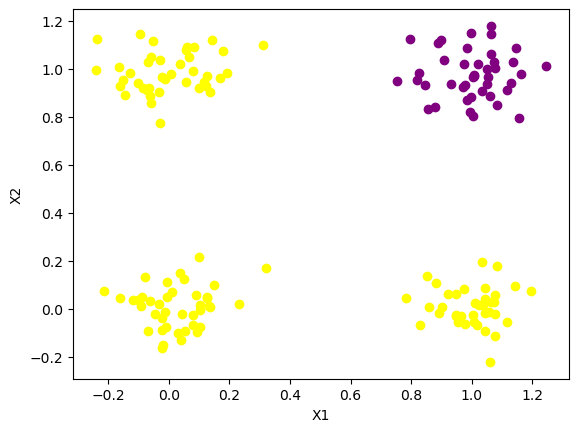

In [32]:
# AND
input_train, target_train, input_test, target_test = get_data(n, 'AND', Tr, mean, std)
plotPoints(input_train, target_train)

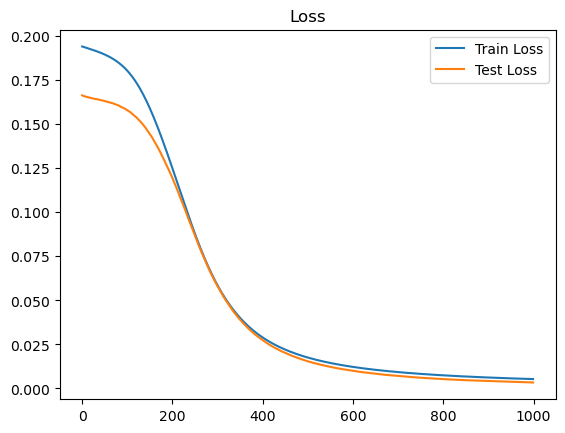

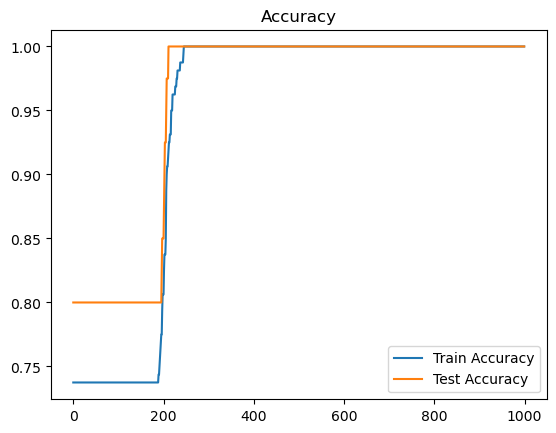

Train Loss: 0.0053371960825959195
Train Accuracy: 1.0
Test Loss: 0.003404430798530679
Test Accuracy: 1.0


In [33]:
and_params = training(input_train, target_train, input_test, target_test, 2, 1, 1000, 0.05, 'stochastic_gradient_descent', m)

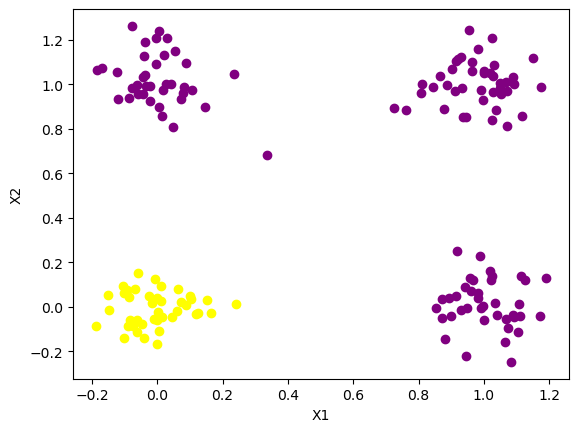

In [34]:
# OR
input_train, target_train, input_test, target_test = get_data(n, 'OR', Tr, mean, std)
plotPoints(input_train, target_train)

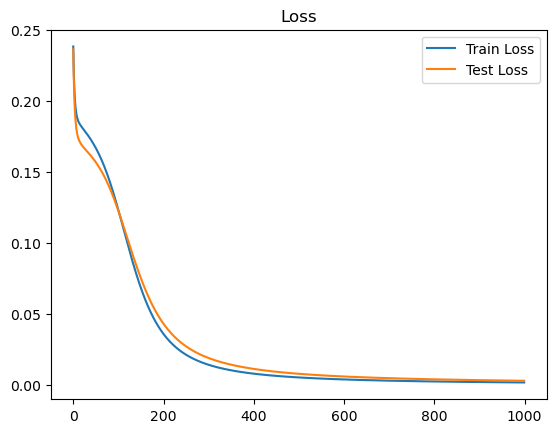

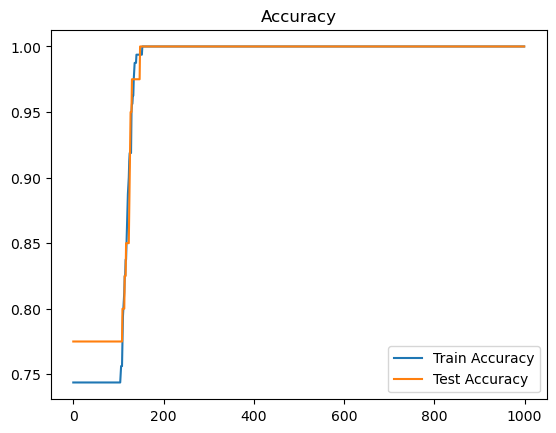

Train Loss: 0.0018488921898532282
Train Accuracy: 1.0
Test Loss: 0.003040884122961454
Test Accuracy: 1.0


In [35]:
or_params = training(input_train, target_train, input_test, target_test, 2, 1, 1000, 0.05, 'stochastic_gradient_descent', m)

In [36]:
# For batch size = 16
m = 16

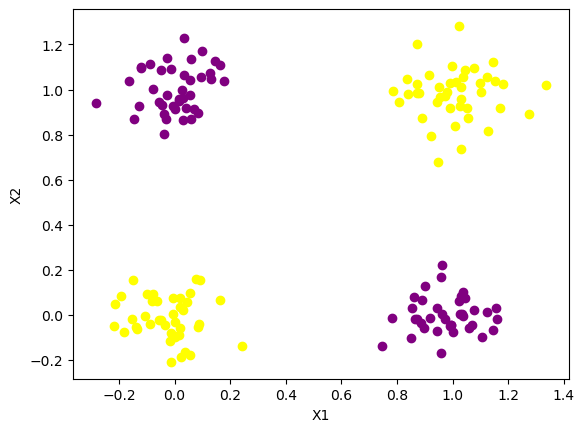

In [37]:
# XOR
input_train, target_train, input_test, target_test = get_data(n, 'XOR', Tr, mean, std)
plotPoints(input_train, target_train)

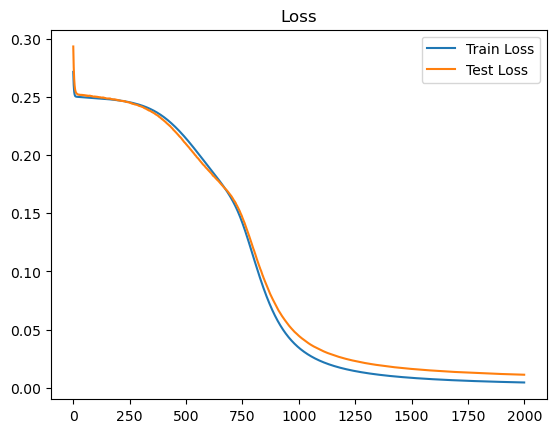

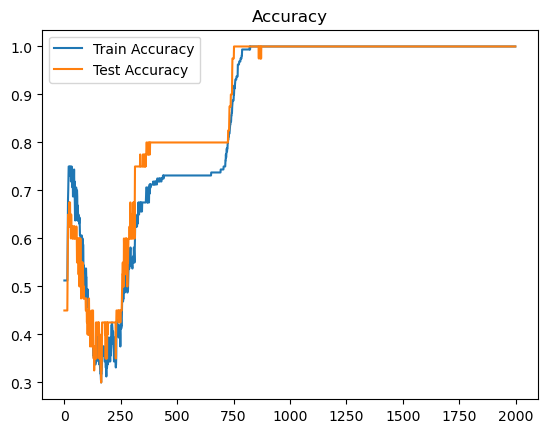

Train Loss: 0.004475851897671065
Train Accuracy: 1.0
Test Loss: 0.011146202958417723
Test Accuracy: 1.0


In [38]:
xor_params = training(input_train, target_train, input_test, target_test, 2, 1, 2000, 0.1, 'stochastic_gradient_descent', m)

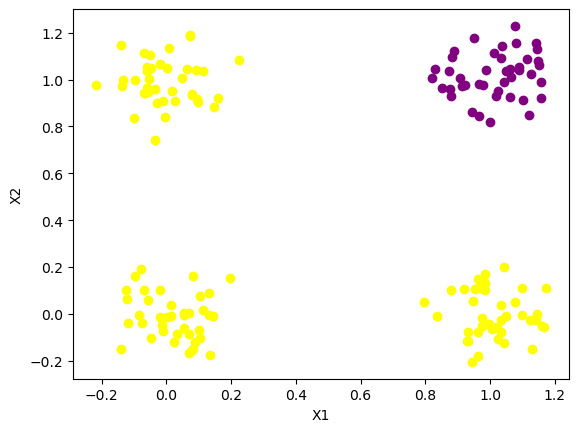

In [39]:
# AND
input_train, target_train, input_test, target_test = get_data(n, 'AND', Tr, mean, std)
plotPoints(input_train, target_train)

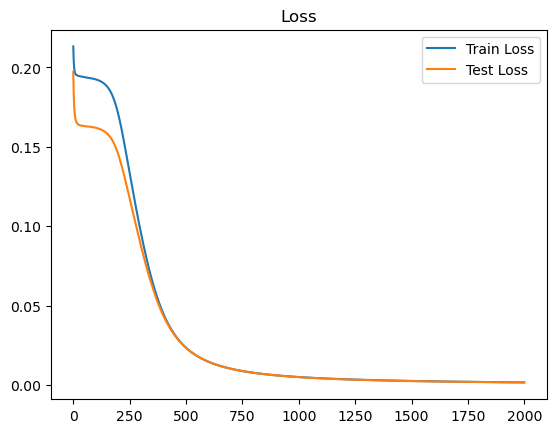

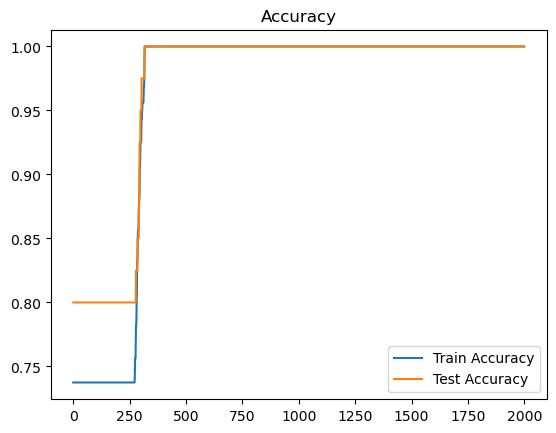

Train Loss: 0.0016910593597935833
Train Accuracy: 1.0
Test Loss: 0.0016362744520302442
Test Accuracy: 1.0


In [40]:
and_params = training(input_train, target_train, input_test, target_test, 2, 1, 2000, 0.1, 'stochastic_gradient_descent', m)

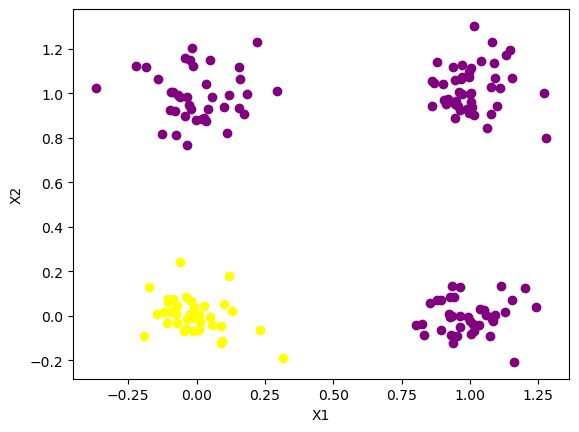

In [41]:
# OR
input_train, target_train, input_test, target_test = get_data(n, 'OR', Tr, mean, std)
plotPoints(input_train, target_train)

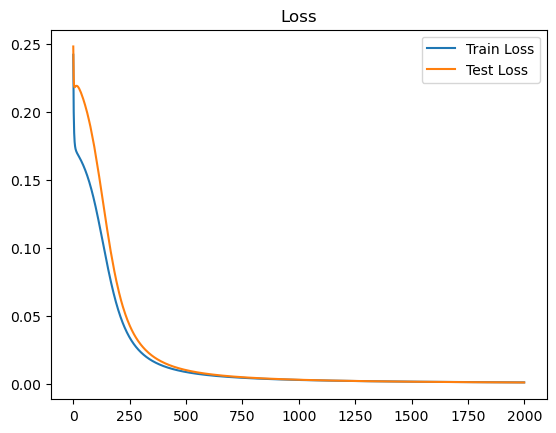

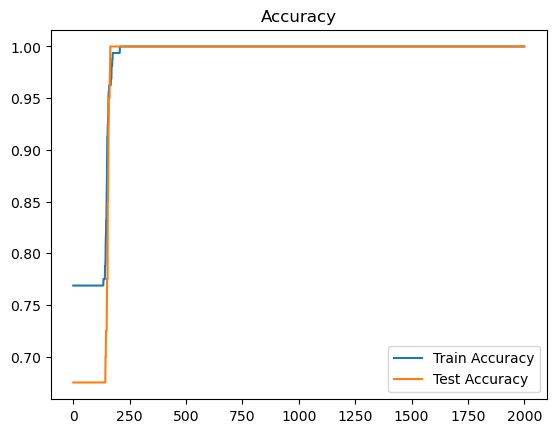

Train Loss: 0.0012146769026777301
Train Accuracy: 1.0
Test Loss: 0.0011537076229292454
Test Accuracy: 1.0


In [42]:
or_params = training(input_train, target_train, input_test, target_test, 2, 1, 2000, 0.1, 'stochastic_gradient_descent', m)

In [43]:
# For batch size = 64
m = 64

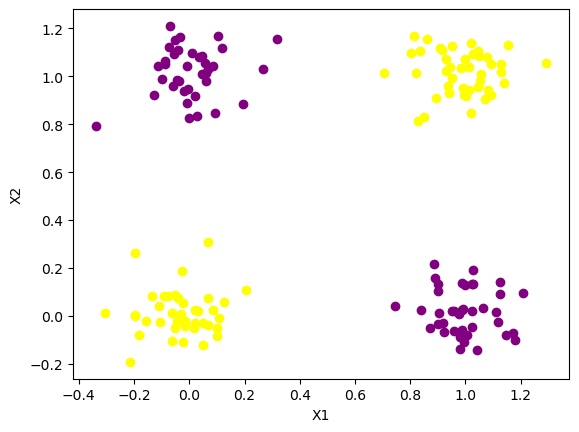

In [44]:
# XOR
input_train, target_train, input_test, target_test = get_data(n, 'XOR', Tr, mean, std)
plotPoints(input_train, target_train)

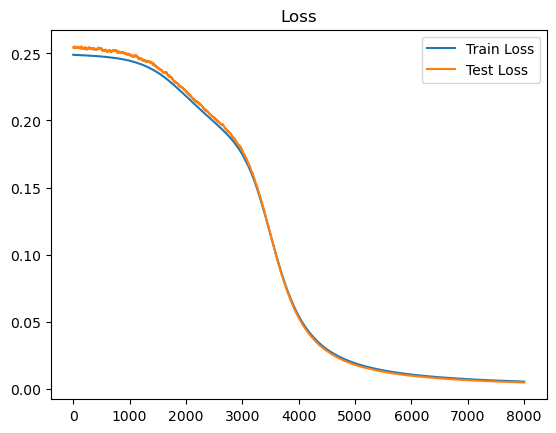

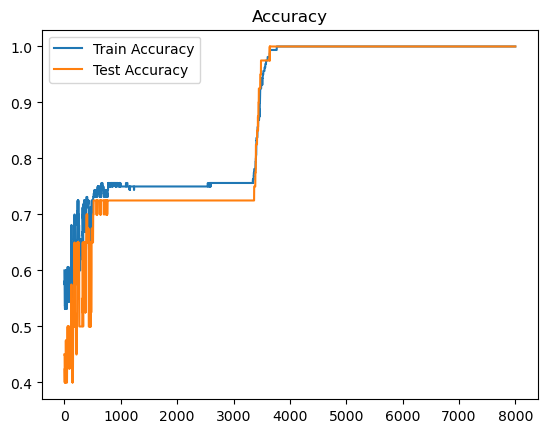

Train Loss: 0.005529524126544136
Train Accuracy: 1.0
Test Loss: 0.004886687021265981
Test Accuracy: 1.0


In [45]:
xor_params = training(input_train, target_train, input_test, target_test, 2, 1, 8000, 0.1, 'stochastic_gradient_descent', m)

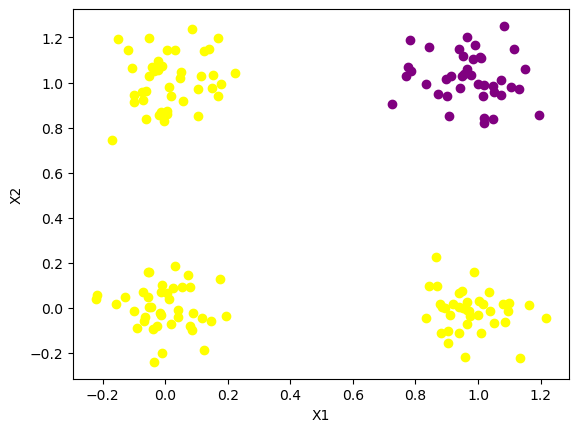

In [46]:
# AND
input_train, target_train, input_test, target_test = get_data(n, 'AND', Tr, mean, std)
plotPoints(input_train, target_train)

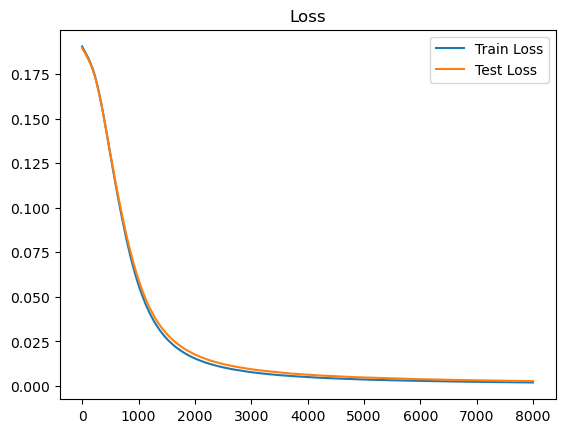

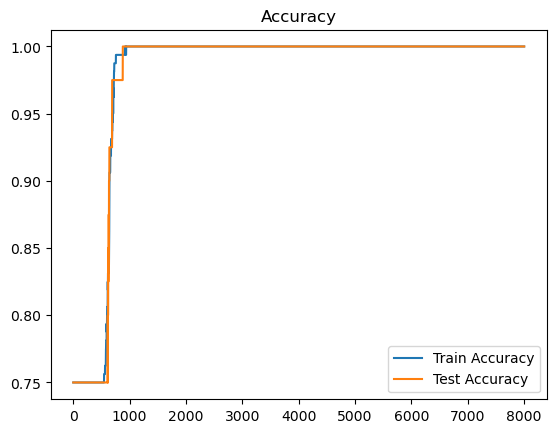

Train Loss: 0.0019927722392734637
Train Accuracy: 1.0
Test Loss: 0.0027649589779254998
Test Accuracy: 1.0


In [47]:
and_params = training(input_train, target_train, input_test, target_test, 2, 1, 8000, 0.1, 'stochastic_gradient_descent', m)

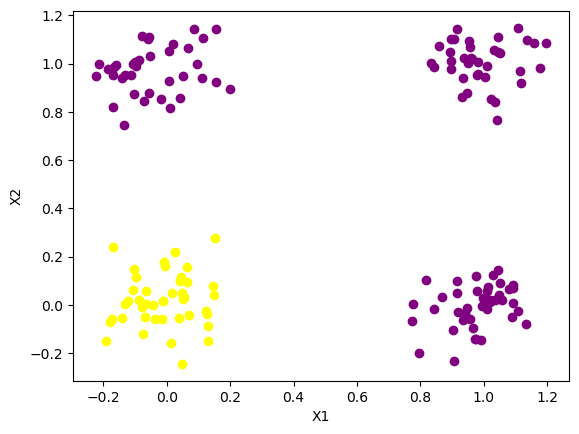

In [48]:
# OR
input_train, target_train, input_test, target_test = get_data(n, 'OR', Tr, mean, std)
plotPoints(input_train, target_train)

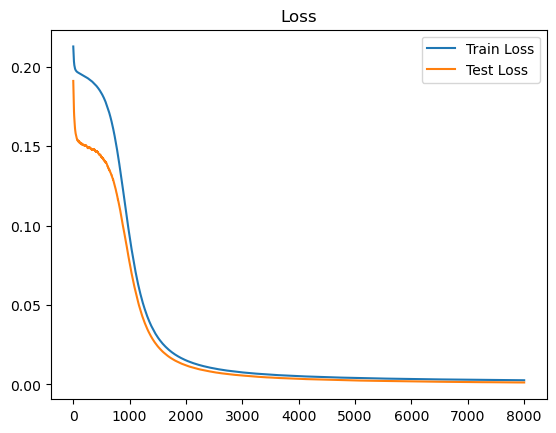

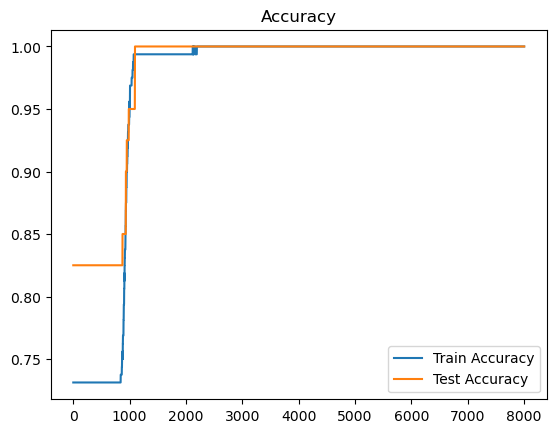

Train Loss: 0.0026356449475707514
Train Accuracy: 1.0
Test Loss: 0.0012383901117507766
Test Accuracy: 1.0


In [49]:
or_params = training(input_train, target_train, input_test, target_test, 2, 1, 8000, 0.1, 'stochastic_gradient_descent', m)

Observations:  

1. As the batch size increases, the training time decreases.  

2. For bigger batch sizes, a bigger learning rate (used 0.05 for m = 16 and 0.1 for m = 64 in case of XOR) and more  
epochs (about 1000 for m = 16, and about 7000 for m = 64 in case of XOR) are required to converge (specifically for XOR).